In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = False
load_gsea = False
run_umap = False

In [2]:
# Parameters
id_ = "Wu_Zhou_2021_NSCLC"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 88325 × 29146
    obs: 'sample', 'patient', 'tissue', 'sex', 'age', 'origin', 'condition', 'platform', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,21_CTTCGGTAATTC,Airway epithelium
1,21_TATCAATACAAG,Airway epithelium
2,21_GCCCGACGTGGT,Airway epithelium
3,21_TTGATAGCTGTC,Airway epithelium
4,21_TGCTGAAAGTGA,Airway epithelium
...,...,...
88320,40_TTATGTAGCGGA,Myeloid
88321,40_GGAGGAGCCCAT,Myeloid
88322,40_AACCTACACACT,Myeloid
88323,40_CAGAGGTGTACG,Myeloid


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['sample', 'patient', 'tissue', 'sex', 'age', 'origin', 'condition',
       'platform', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mito', 'pct_counts_mito', 'barcode_', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Tumor
1,1,Tumor
2,2,Tumor
3,3,Tumor
4,4,Tumor
...,...,...
88320,88320,Tumor
88321,88321,Tumor
88322,88322,Tumor
88323,88323,Tumor


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0        tumor_primary
1        tumor_primary
2        tumor_primary
3        tumor_primary
4        tumor_primary
             ...      
88320    tumor_primary
88321    tumor_primary
88322    tumor_primary
88323    tumor_primary
88324    tumor_primary
Name: origin, Length: 88325, dtype: category
Categories (1, object): ['tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary    88325
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [13]:
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [14]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [15]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_142885/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
GSM4453576    5316
GSM4453577     306
GSM4453578    7829
GSM4453579    4525
GSM4453580    2444
GSM4453581    3064
GSM4453582    3006
GSM4453583    1333
GSM4453584    3518
GSM4453585    3740
GSM4453586     569
GSM4453587     884
GSM4453588     934
GSM4453589    1794
GSM4453590    3428
GSM4453591    1143
GSM4453592    8700
GSM4453593    3289
GSM4453594     436
GSM4453595     429
GSM4453596    1968
GSM4453597     614
GSM4453598    2387
GSM4453599     362
GSM4453600    4027
GSM4453601     278
GSM4453602     358
GSM4453603    2361
GSM4453604     969
GSM4453605     742
GSM4453606     387
GSM4453607     590
GSM4453608     350
GSM4453609     967
GSM4453610    1078
GSM4453611     368
GSM4453612    2484
GSM4453613    1344
GSM4453614    1893
GSM4453615    1060
GSM4453616    6220
GSM4453617     831
Name: patient, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [16]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0        Airway epithelium_TT_Tumor
1        Airway epithelium_TT_Tumor
2        Airway epithelium_TT_Tumor
3        Airway epithelium_TT_Tumor
4        Airway epithelium_TT_Tumor
                    ...            
88320              Myeloid_TT_Tumor
88321              Myeloid_TT_Tumor
88322              Myeloid_TT_Tumor
88323              Myeloid_TT_Tumor
88324              Myeloid_TT_Tumor
Name: type_tissue, Length: 88325, dtype: category
Categories (20, object): ['Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal', 'Alveolar epithelium_TT_Tumor', ..., 'Smooth muscle_TT_Tumor', 'Submucosal Gland_TT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [17]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Submucosal Gland', 'Unknown'],
      dtype='object')

In [18]:
adata.obs['type_tissue'].value_counts()

type_tissue
Airway epithelium_TT_Tumor       40761
Myeloid_TT_Tumor                 14593
Airway epithelium_TT_Normal       6787
Unknown_TT_Normal                 4607
Lymphoid_TT_Normal                4339
Unknown_TT_Tumor                  3800
Fibroblast lineage_TT_Normal      3771
Lymphoid_TT_Tumor                 3017
Alveolar epithelium_TT_Normal     2818
Myeloid_TT_Normal                 1269
Alveolar epithelium_TT_Tumor      1132
Blood vessels_TT_Normal           1035
Smooth muscle_TT_Normal            314
Blood vessels_TT_Tumor              49
Lymphatic EC_TT_Normal              13
Fibroblast lineage_TT_Tumor         11
Submucosal Gland_TT_Normal           5
Mesothelium_TT_Normal                2
Lymphatic EC_TT_Tumor                1
Smooth muscle_TT_Tumor               1
Name: count, dtype: int64

In [19]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [20]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [21]:
valid_types

['Airway epithelium_TT_Tumor',
 'Myeloid_TT_Tumor',
 'Airway epithelium_TT_Normal',
 'Unknown_TT_Normal',
 'Lymphoid_TT_Normal',
 'Unknown_TT_Tumor',
 'Fibroblast lineage_TT_Normal',
 'Lymphoid_TT_Tumor',
 'Alveolar epithelium_TT_Normal',
 'Myeloid_TT_Normal',
 'Alveolar epithelium_TT_Tumor',
 'Blood vessels_TT_Normal',
 'Smooth muscle_TT_Normal',
 'Blood vessels_TT_Tumor',
 'Lymphatic EC_TT_Normal',
 'Fibroblast lineage_TT_Tumor',
 'Submucosal Gland_TT_Normal']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Mesothelium_TT_Tumor']
['Mesothelium_TT_Tumor', 'Mesothelium_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Submucosal Gland_TT_Tumor']
['Submucosal Gland_TT_Tumor', 'Submucosal Gland_TT_Normal']
['Unknown_TT_Tumor']


['Unknown_TT_Tumor', 'Unknown_TT_Normal']


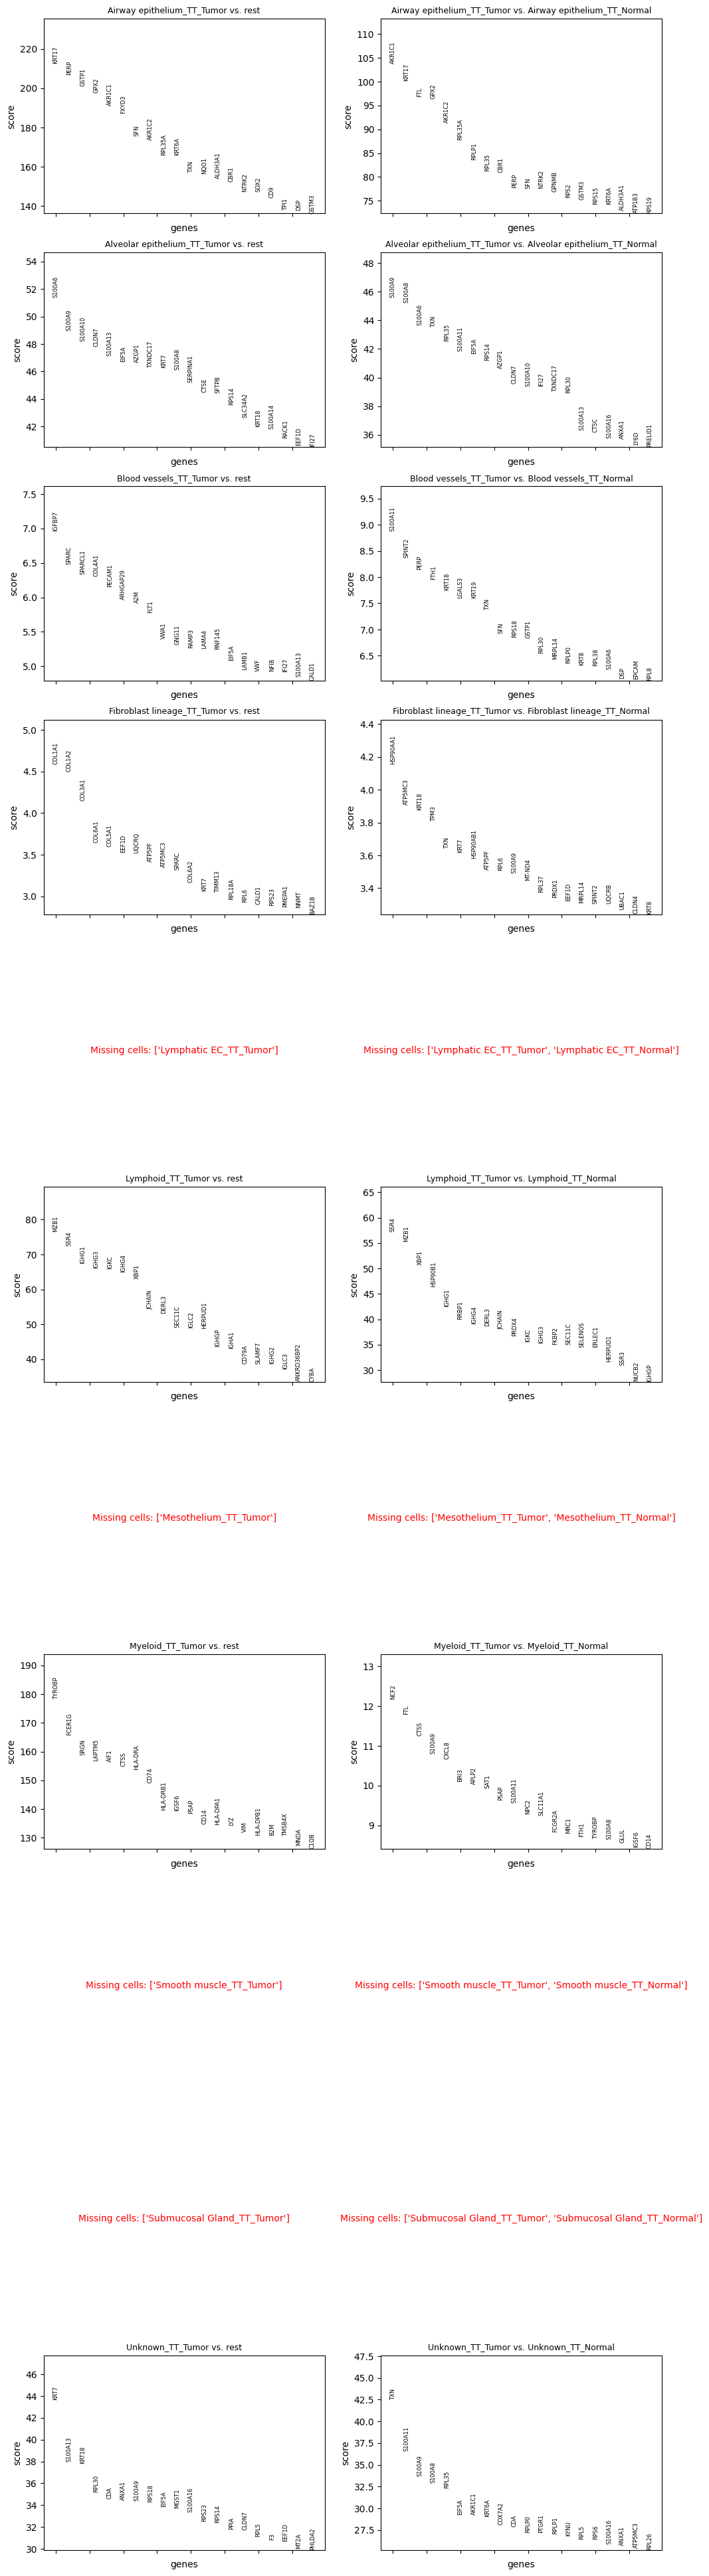

In [22]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [23]:
adata.obs.origin.str.contains('normal').any()

False

In [24]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

/tmp/ipykernel_142885/3062282855.py:27: UserWarning: No healthy tissue!
  warn('No healthy tissue!')


## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Airway epithelium_TT_Tumor, Myeloid_TT_Tumor, Airway epithelium_TT_Normal, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


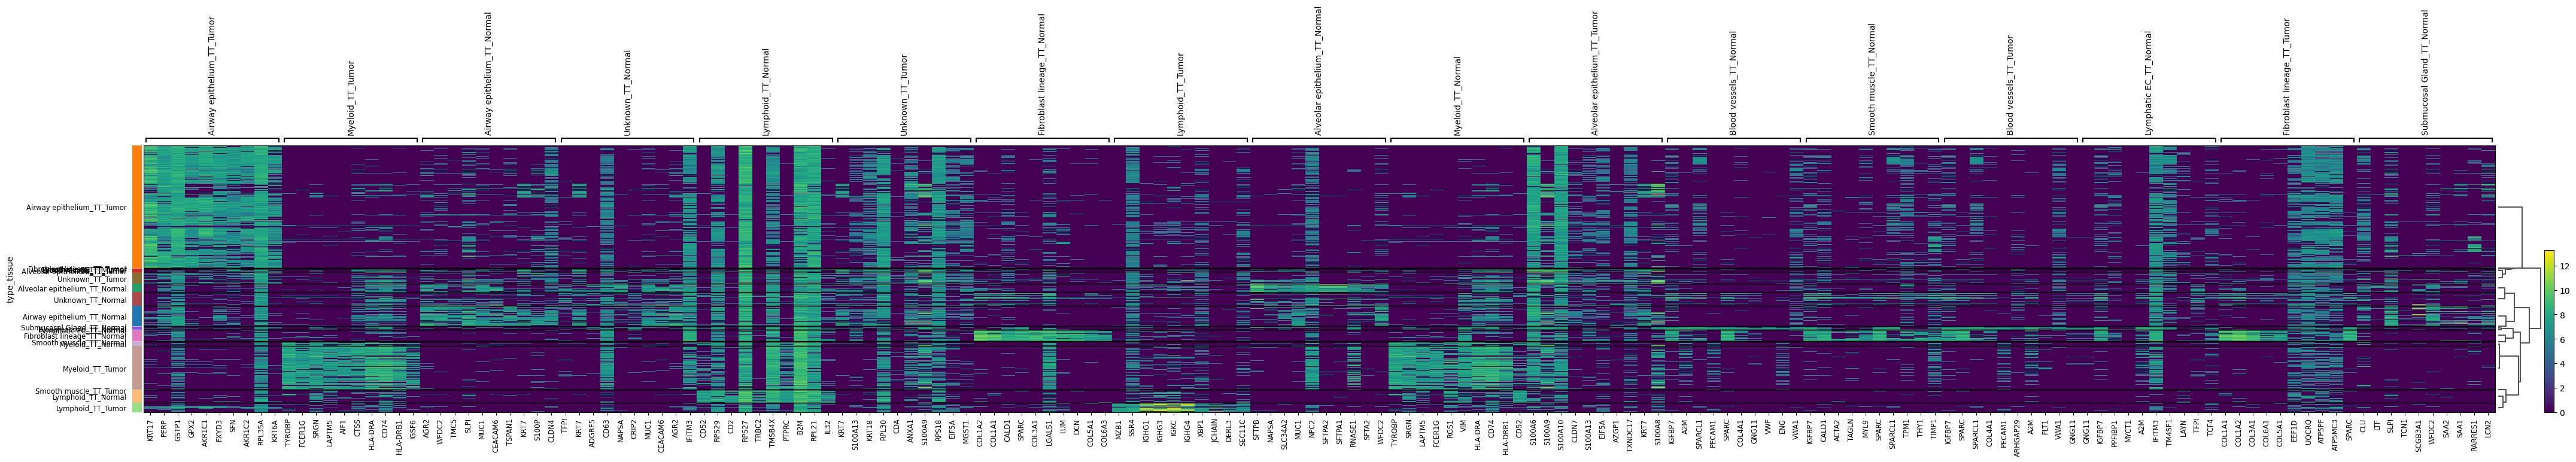

In [25]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [26]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [27]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [28]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [29]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [30]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [31]:
types = adata.obs.loc[lambda x: x['final_pred']== 'Tumor' ]['type_tissue'].unique()

combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)

/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:30:58,479 [WARNING] Duplicated values found in preranked stats: 18.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:30:59,335 [WARNING] Duplicated values found in preranked stats: 26.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:00,256 [WARNING] Duplicated values found in preranked stats: 56.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:01,091 [WARNING] Duplicated values found in preranked stats: 20.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:01,931 [WARNING] Duplicated values found in preranked stats: 13.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:02,775 [WARNING] Duplicated values found in preranked stats: 46.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:03,594 [WARNING] Duplicated values found in preranked stats: 29.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


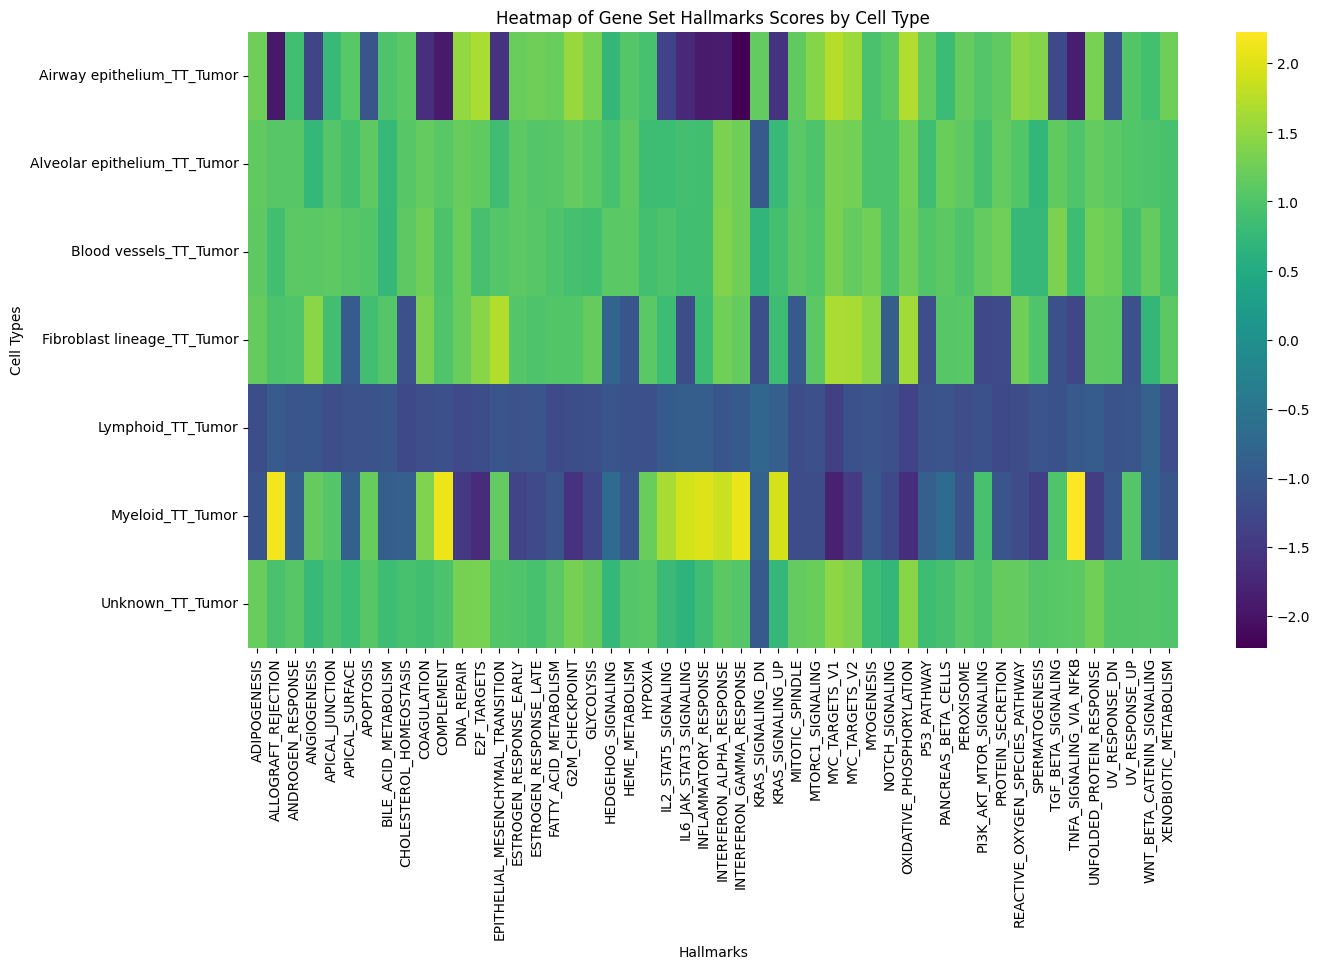

In [32]:
# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

In [33]:
types = adata.obs.loc[lambda x: x['final_pred']== 'Normal' ]['type_tissue'].unique()

combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea)

/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:05,573 [WARNING] Duplicated values found in preranked stats: 30.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:06,395 [WARNING] Duplicated values found in preranked stats: 18.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:07,312 [WARNING] Duplicated values found in preranked stats: 26.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:08,180 [WARNING] Duplicated values found in preranked stats: 31.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:09,075 [WARNING] Duplicated values found in preranked stats: 32.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:09,990 [WARNING] Duplicated values found in preranked stats: 43.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:10,904 [WARNING] Duplicated values found in preranked stats: 60.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:11,706 [WARNING] Duplicated values found in preranked stats: 17.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:12,594 [WARNING] Duplicated values found in preranked stats: 58.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142885/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:31:13,607 [WARNING] Duplicated values found in preranked stats: 24.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


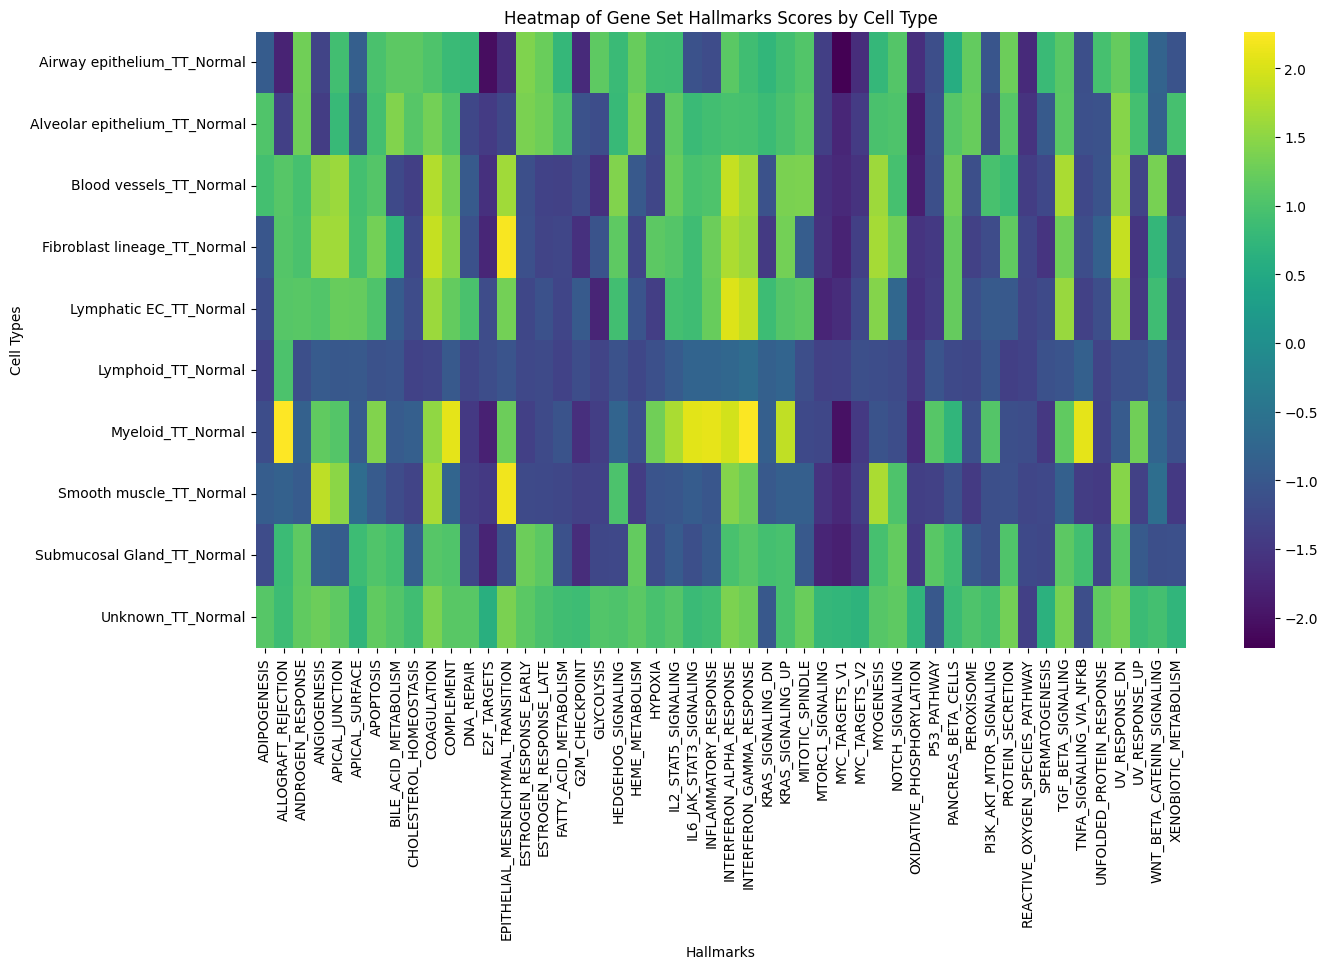

In [34]:
# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()